In [2]:
import pandas as pd
import numpy as np
import ephem
from meteostat import Point, Daily
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.stats import chi2_contingency


In [3]:
''' Here we have our cities. 

    Our two cities on the east will be Boston, MA and Virginia Key, FL
    Miami did not have a designated NOAA station, so the station in Virginia Key, Florida was the closest one. 

    Our two cities on the west coast will be Seattle, WA and Los Angeles, CA.
    To have recent but consistent data, we have taken the data from the years 2019-2023'''

cities = {
    "Seattle": {"lat": 47.6062, "lon": -122.3321, "threshold": 13.45},
    "Florida": {"lat": 25.7617, "lon": -80.1918, "threshold": 3.53},
    "Boston": {"lat": 42.3601, "lon": -71.0589, "threshold": 12.5},
    "LA": {"lat": 34.0522, "lon": -118.2437, "threshold": 6.99}
}

years = range(2019, 2024)
data_folder = "data"

In [4]:
# This function will iterate through our data folder and pick out the csv files for each, loading it for use.

def load_city_data(city_name):
    dfs = []
    for year in years:
        file_path = f"{data_folder}/tide_height_{city_name.lower()}_{year}.csv"
        df = pd.read_csv(file_path)
        df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time (GMT)"])
        df = df.set_index("Datetime").drop(columns=["Date", "Time (GMT)", "Preliminary (ft)"])
        dfs.append(df)
    return pd.concat(dfs)

# Since our csv files come with hourly data, we will reformat them to showcase daily mean tides, while also adding a flood-watch 0.5ft buffer.
# We do NOT merge all 4 datasets into one big one because the minor flooding thresholds are different per city based on historic data.
# Doing so can affect how we categorize what a flood instance is, because a flood in Seattle could be nowhere near a flood in Boston.

def process_daily_tides(df, threshold):
    daily_df = df.resample("D").agg({
        "Predicted (ft)": "mean",
        "Verified (ft)": ["mean", "max", "min"]
    })
    daily_df.columns = ["Predicted_mean","Verified_mean","Verified_max","Verified_min"]
    
    # Label minor floods and near-floods
    daily_df["Minor_Flood"] = daily_df["Verified_max"] > threshold
    buffer = 0.5
    daily_df["Close_to_Flood"] = (
        (daily_df["Verified_max"] > (threshold - buffer)) &
        (daily_df["Verified_max"] <= threshold)
    )
    return daily_df

In [5]:
''' These functions are key. 

    get_moon_phase uses pyephem to get the daily moon phases, which is easier than scrubbing through weather data.
     
    categorize_phase will be used for modeling. A moon that is less than 10% visible or more than 90% visible is a new or full moon.
    We combine these because they are our parallel allignment phases, or phases that we predict will be more likely to cause flooding.
    Less than 40 or greater than 60 is a quarter moon, and everything in-betweeen is intermediate. These are less likely to cause floodings
    because they are phases where the allingment does not pull on the earth's tides.

    Finally, add_moon_phase adds this to our datasets. 

'''

def get_moon_phase(date):
    if isinstance(date, pd.Timestamp):
        date = date.date()
    return ephem.Moon(date).phase

def categorize_phase(phase):
    if phase < 10 or phase > 90:
        return "New/Full Moon"
    elif 40 < phase < 60:
        return "Quarter Moon"
    else:
        return "Intermediate"

def add_moon_phase(df):
    df["Moon_Phase"] = [get_moon_phase(d) for d in df.index]
    df["Phase_Category"] = df["Moon_Phase"].apply(categorize_phase)
    return df


In [6]:
''' While we are not hyperfocusing on exploring the effects of earthly weather on tides, it is true that its effect is non-negligible.

    We will use meteostat to get the weather data, and we will use some of its features.

'''

def add_weather_data(df, lat, lon):
    point = Point(lat, lon)
    weather_dfs = []
    for year in years:
        start = datetime(year, 1, 1)
        end = datetime(year, 12, 31)
        weather = Daily(point, start, end).fetch()
        weather.index = pd.to_datetime(weather.index)
        weather_dfs.append(weather)
    weather_df = pd.concat(weather_dfs)
    return df.merge(weather_df, left_index=True, right_index=True, how="inner")


In [7]:
# These will be our final datasets for each city.

city_dfs = {}

for city, info in cities.items():
    raw_df = load_city_data(city)
    daily_df = process_daily_tides(raw_df, info["threshold"])
    daily_df = add_moon_phase(daily_df)
    final_df = add_weather_data(daily_df, info["lat"], info["lon"])
    city_dfs[city] = final_df


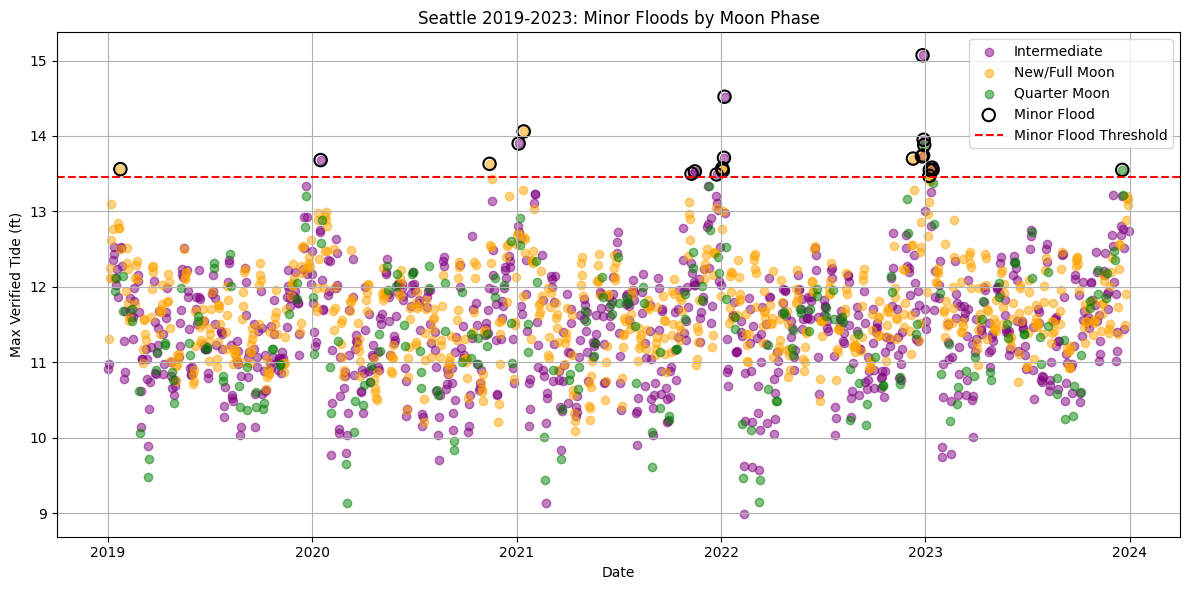

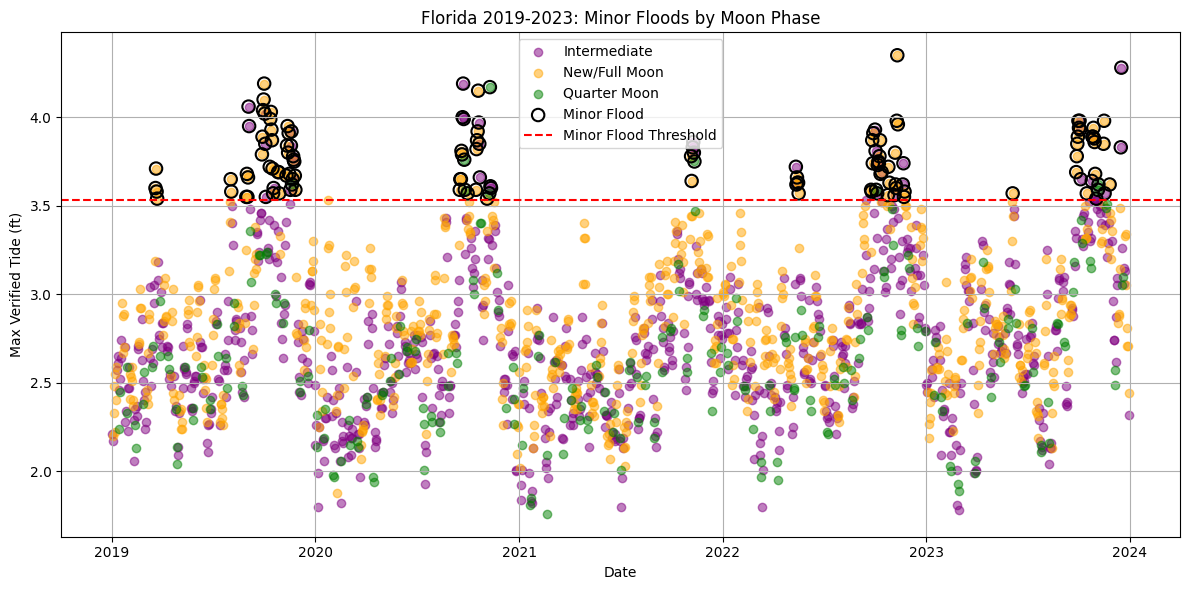

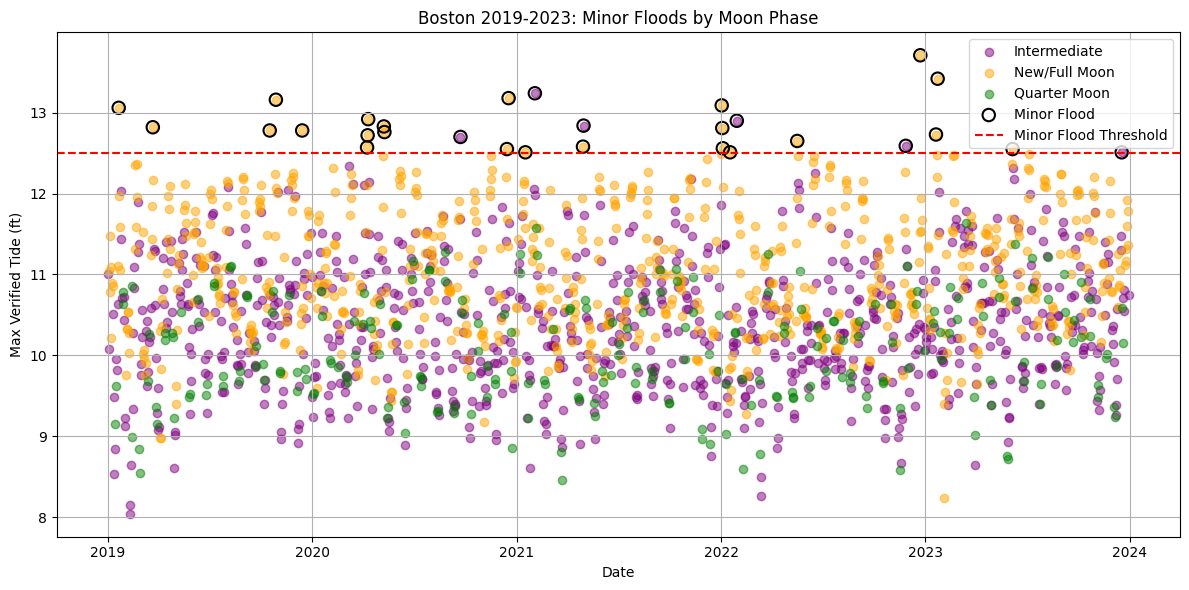

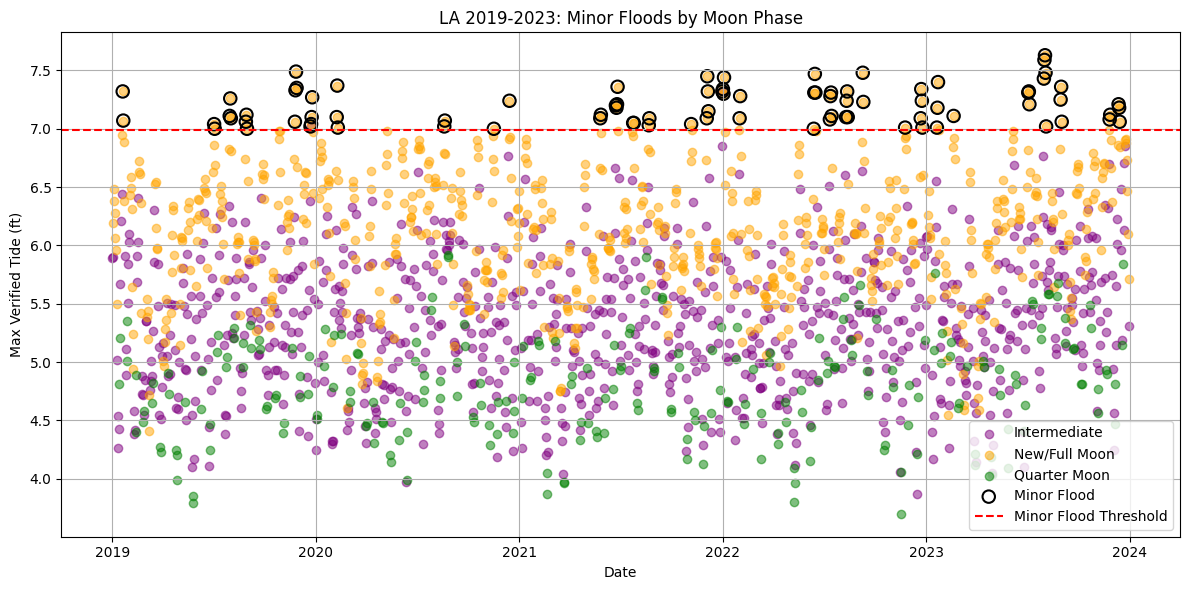

In [8]:
# For each of our cities, we will plot each day's instance, color-coded with that day's moon phase. 
# Instances above the threshold will be considered floods.

colors = {"New/Full Moon":"orange", "Quarter Moon":"green", "Intermediate":"purple"}

for city, df in city_dfs.items():
    plt.figure(figsize=(12,6))
    for phase in df["Phase_Category"].unique():
        subset = df[df["Phase_Category"] == phase]
        plt.scatter(subset.index, subset["Verified_max"], color=colors[phase], alpha=0.5, label=phase)
    plt.scatter(df[df["Minor_Flood"]].index, df[df["Minor_Flood"]]["Verified_max"], 
                facecolors='none', edgecolors='black', s=80, linewidths=1.5, label="Minor Flood")
    plt.axhline(y=cities[city]["threshold"], color='red', linestyle='--', label='Minor Flood Threshold')
    plt.title(f"{city} 2019-2023: Minor Floods by Moon Phase")
    plt.xlabel("Date")
    plt.ylabel("Max Verified Tide (ft)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
# We will calculate the Moon Influence Score, which is a function
# that will calculate the actual impact of the moon phase on the instances

def compute_moon_influence(df):
    floods = df[df["Minor_Flood"]]
    if len(floods) == 0:
        return None
    phase_counts = floods["Phase_Category"].value_counts(normalize=True)
    newfull = phase_counts.get("New/Full Moon", 0)
    quarter = phase_counts.get("Quarter Moon", 0)
    return newfull - quarter

# Compute for each city
moon_scores = []
chi_results = []

for city, df in city_dfs.items():
    # Moon Influence Score
    score = compute_moon_influence(df)
    moon_scores.append({"City": city, "Moon_Influence_Score": score})
    
    # Chi-square test
    contingency = pd.crosstab(df["Phase_Category"], df["Minor_Flood"])
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi_results.append({"City": city, "Chi2": chi2, "p_value": p, "Degrees_of_Freedom": dof})

moon_scores_df = pd.DataFrame(moon_scores)
chi_results_df = pd.DataFrame(chi_results)

display(moon_scores_df)
display(chi_results_df)


,City,Moon_Influence_Score
0,Seattle,0.304348
1,Florida,0.564286
2,Boston,0.793103
3,LA,0.976471


,City,Chi2,p_value,Degrees_of_Freedom
0,Seattle,0.511765,7.742328e-01,2
1,Florida,33.183613,6.226871e-08,2
2,Boston,19.470387,5.916421e-05,2
3,LA,123.001190,1.952679e-27,2


In [10]:
weather_model_results = []

for city, df in city_dfs.items():
    
    # drop rows with missing weather data
    model_df = df.dropna(subset=["tavg", "wspd", "prcp"])
    
    # encode moon phase as a categorical dummy variable
    dummies = pd.get_dummies(model_df["Phase_Category"], drop_first=True)

    # select features
    X = pd.concat([
        model_df[["tavg", "wspd", "prcp"]],  
        dummies                              
    ], axis=1)

    y = model_df["Minor_Flood"].astype(int)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # logistic regression model
    model = LogisticRegression(max_iter=500)
    model.fit(X_train, y_train)

    # evaluation
    print(f"\n--- {city} ---")
    print(classification_report(y_test, model.predict(X_test)))

    # save summary
    coef_df = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": model.coef_[0]
    })
    
    weather_model_results.append((city, coef_df))

# display coefficients neatly
for city, coef_df in weather_model_results:
    print(f"\n=== {city}: Feature Importance (Logistic Regression Coefficients) ===")
    display(coef_df.sort_values("Coefficient", ascending=False))


--- Seattle ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       360
           1       0.00      0.00      0.00         5

    accuracy                           0.99       365
   macro avg       0.49      0.50      0.50       365
weighted avg       0.97      0.99      0.98       365


--- Florida ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       338
           1       0.00      0.00      0.00        28

    accuracy                           0.92       366
   macro avg       0.46      0.50      0.48       366
weighted avg       0.85      0.92      0.89       366


--- Boston ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       360
           1       1.00      0.17      0.29         6

    accuracy                           0.99       366
   macro avg       0.99      0.58      0.64       366
weighted avg       0.99 

,Feature,Coefficient
1,wspd,0.183767
2,prcp,0.043451
3,New/Full Moon,0.019074
0,tavg,-0.193391
4,Quarter Moon,-0.499537



=== Florida: Feature Importance (Logistic Regression Coefficients) ===


,Feature,Coefficient
3,New/Full Moon,0.899499
0,tavg,0.041060
1,wspd,0.037204
2,prcp,0.014916
4,Quarter Moon,-0.468645



=== Boston: Feature Importance (Logistic Regression Coefficients) ===


,Feature,Coefficient
3,New/Full Moon,1.432116
1,wspd,0.131787
2,prcp,0.044915
0,tavg,-0.029645
4,Quarter Moon,-0.704355



=== LA: Feature Importance (Logistic Regression Coefficients) ===


,Feature,Coefficient
3,New/Full Moon,2.954350
0,tavg,0.038080
1,wspd,0.026344
2,prcp,0.014940
4,Quarter Moon,-0.648296


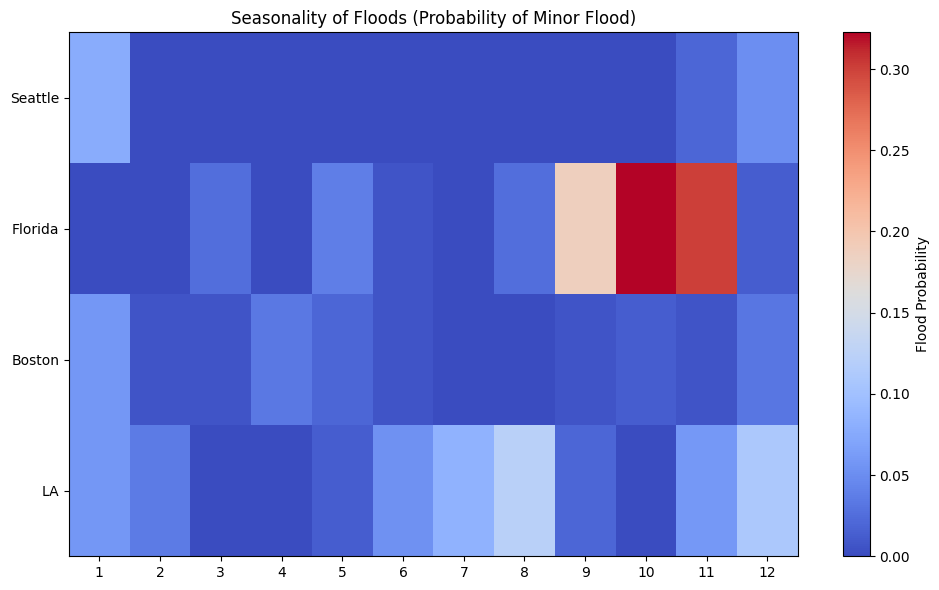

In [11]:
city_names, heatmap_matrix = [], []

for city, df in city_dfs.items():
    _df = df.copy()
    _df["month"] = _df.index.month
    monthly = _df.groupby("month")["Minor_Flood"].mean().reindex(range(1,13), fill_value=0)
    city_names.append(city)
    heatmap_matrix.append(monthly.values)

heatmap_matrix = np.array(heatmap_matrix)

plt.figure(figsize=(10,6))
plt.imshow(heatmap_matrix, cmap="coolwarm", aspect="auto")
plt.colorbar(label="Flood Probability")
plt.yticks(range(len(city_names)), city_names)
plt.xticks(range(12), range(1,13))
plt.title("Seasonality of Floods (Probability of Minor Flood)")
plt.tight_layout()
plt.show()
